### Step 1: Importing Libraries
The first step is to import the following list of libraries:

In [1]:
# Import libraries for text pre-processing
import sys, os, re, csv, string, codecs, numpy as np, pandas as pd
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation

#for model-building
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import  Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

#for word embedding
import gensim
from gensim.models import Word2Vec

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Step 2: Loading the data set & EDA¶
The dataset that I will be using for this project is the famous “Natural Language Processing with Disaster Tweets” data set where we’ll be predicting whether a given tweet is about a real disaster (target=1) or not (target=0)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
train = pd.read_csv('train.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Exploratory Data Analysis (EDA)
1. Target class distribution
2. Missing values
3. Number of words and character counts

### 1. Target class distribution

In [5]:
# Parameters
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

target_class = train['target'].value_counts()
print(target_class)

0    4342
1    3271
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Real Disaster Tweet')

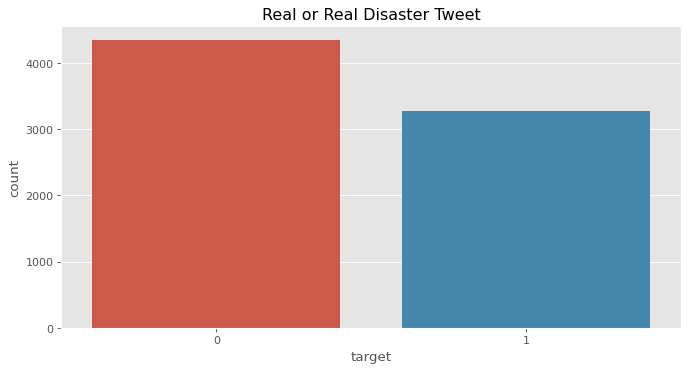

In [6]:
sns.countplot('target', data = train)
plt.title('Real or Real Disaster Tweet')

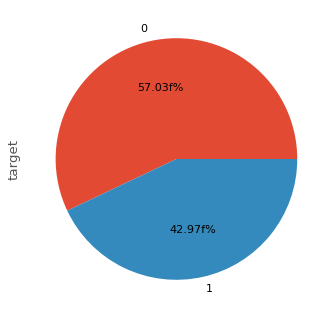

In [7]:
train['target'].value_counts().plot.pie(autopct='%1.2ff%%')

There are more tweets with no disaster (class 0) than disaster tweets (class 1). Apparently, the dataset is balanced with 4342 non-disaster tweets (57%) and 3271 disaster tweets (43%). Therefore, there is no need to apply data-balancing techniques since the data is balanced relatively.

### 2. Number of characters in a tweet (character_count)



In [8]:
pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-0eg7wnob
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-0eg7wnob
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=cd9891ba3c36be43f0daa684f4762c0695eb126bc8fd0b8aba1d53eebae75ef8
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1pf30k2/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [9]:
import preprocess_kgptalkie as kgp

train = kgp.get_basic_features(train)
train.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


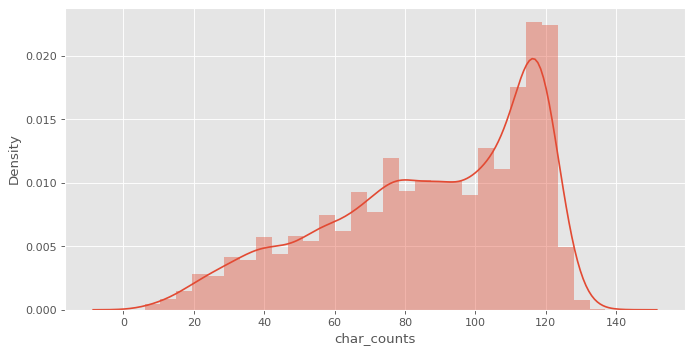

In [10]:
sns.distplot(train['char_counts'])

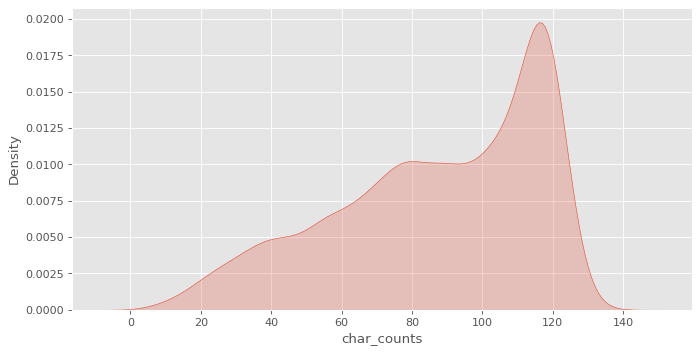

In [11]:
sns.kdeplot(train['char_counts'], shade=True)

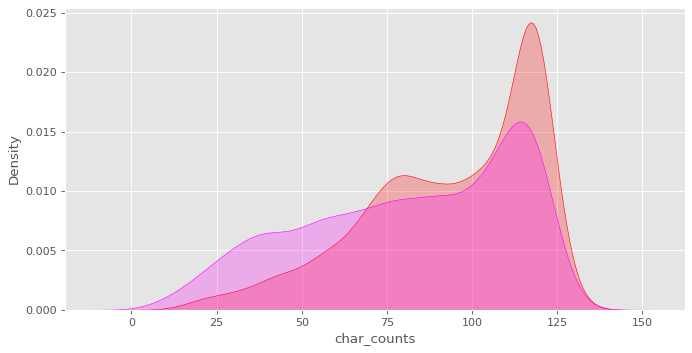

In [12]:
sns.kdeplot(train[train['target'] == 1]['char_counts'], shade=True, color = 'red')
sns.kdeplot(train[train['target'] == 0]['char_counts'], shade=True, color = 'magenta')

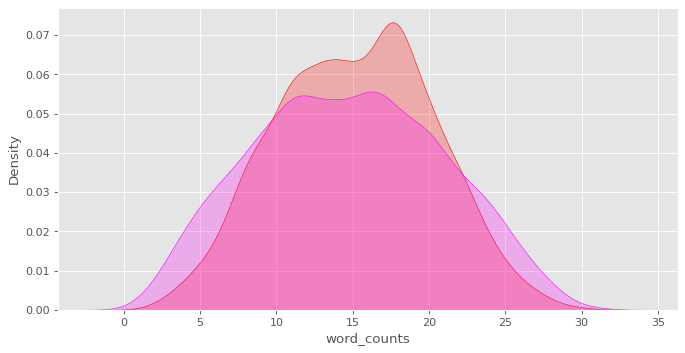

In [13]:
sns.kdeplot(train[train['target'] == 1]['word_counts'], shade=True, color = 'red')
sns.kdeplot(train[train['target'] == 0]['word_counts'], shade=True, color = 'magenta')

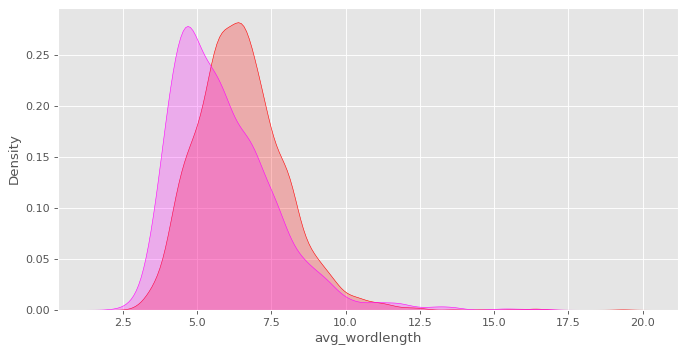

In [14]:
sns.kdeplot(train[train['target'] == 1]['avg_wordlength'], shade=True, color = 'red')
sns.kdeplot(train[train['target'] == 0]['avg_wordlength'], shade=True, color = 'magenta')

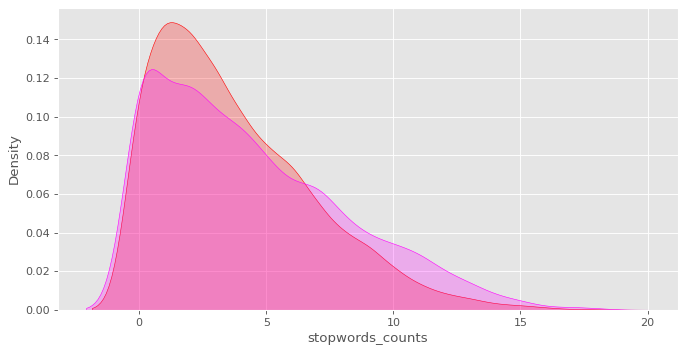

In [15]:
sns.kdeplot(train[train['target'] == 1]['stopwords_counts'], shade=True, color = 'red')
sns.kdeplot(train[train['target'] == 0]['stopwords_counts'], shade=True, color = 'magenta')

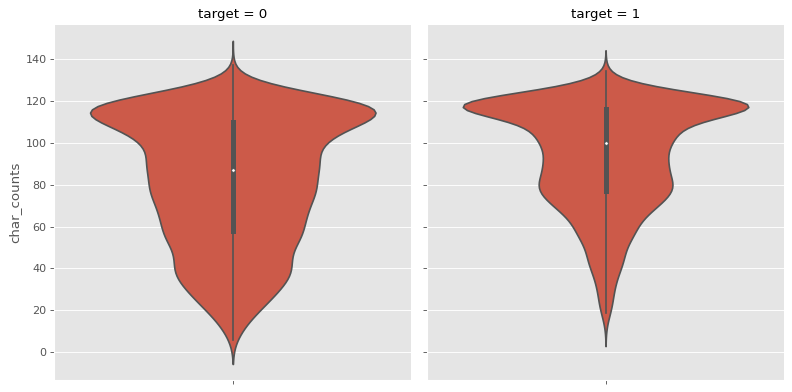

In [16]:
sns.catplot(y = 'char_counts', data = train, kind = 'violin', col = 'target')

### Most and least common words

In [17]:
freqs = kgp.get_word_freqs(train, 'text')
freqs[:10]

the    2575
a      1845
to     1805
in     1757
of     1722
and    1302
I      1197
for     820
is      814
on      773
dtype: int64

<BarContainer object of 20 artists>

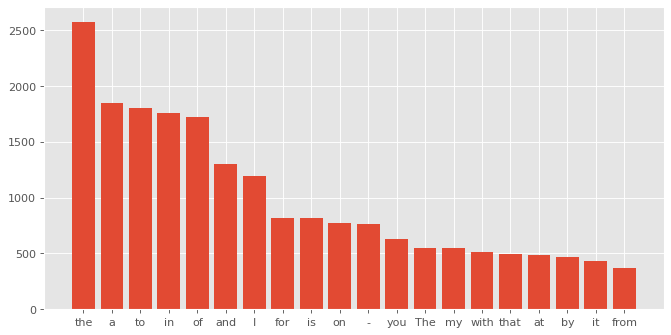

In [18]:
top20 = freqs[:20]
plt.bar(top20.index, top20.values)

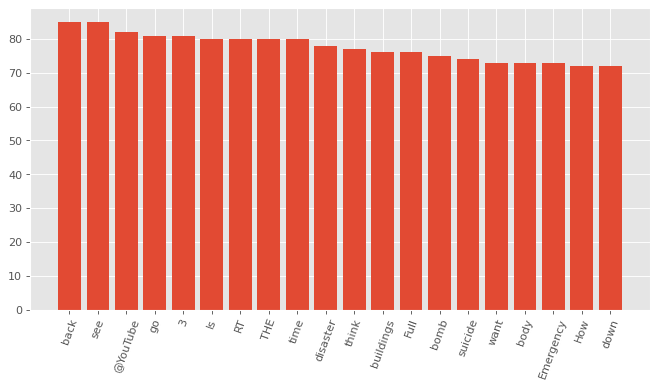

In [19]:
top120 = freqs[100:120]

plt.bar(top120.index, top120.values)
plt.xticks(rotation = 70)
plt.show()

In [20]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [21]:
kgp.get_ngram(train, 'text', ngram_range=2)

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476),
 ('ûó bulletproof', 68475),
 ('ûó britain', 68474),
 ('ûó bbc', 68473),
 ('ûó and', 68472),
 ('ûó an', 68471),
 ('ûòåêcnbc http', 68470),
 ('ûòthe united', 68469),
 ('ûò800000 fatalities', 68468),
 ('ûò ûïdetonate', 68467),
 ('ûò your', 68466),
 ('ûò vladimir', 68465),
 ('ûò video', 68464),
 ('ûò usa', 68463),
 ('ûò two', 68462),
 ('ûò those', 68461),
 ('ûò the', 68460),
 ('ûò steve', 68459),
 ('ûò skyåênews', 68458),
 ('ûò residents', 68457),
 ('ûò part', 68456),
 ('ûò news', 68455),
 ('ûò musicians', 68454),
 ('ûò mo

One - Short Data Cleaning

In [22]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('_', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [23]:
train['text'] = train['text'].apply(lambda x: get_clean(x))

In [24]:
train.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [25]:
kgp.get_ngram(train, 'text', ngram_range=2)

[('zxathetis are', 60256),
 ('zurich for', 60255),
 ('zumiez is', 60254),
 ('zss vs', 60253),
 ('zourryart forgot', 60252),
 ('zouma just', 60251),
 ('zouma has', 60250),
 ('zotar50 skeleton', 60249),
 ('zoom in', 60248),
 ('zonewolf123 liked', 60247),
 ('zonesthank god', 60246),
 ('zones donuat', 60245),
 ('zone with', 60244),
 ('zone what', 60243),
 ('zone war', 60242),
 ('zone they', 60241),
 ('zone protectdenaliwolves', 60240),
 ('zone outside', 60239),
 ('zone of', 60238),
 ('zone my', 60237),
 ('zone littlewomenla', 60236),
 ('zone laugh', 60235),
 ('zone johnny', 60234),
 ('zone in', 60233),
 ('zone during', 60232),
 ('zone common', 60231),
 ('zone coming', 60230),
 ('zone but', 60229),
 ('zone and', 60228),
 ('zone amirite', 60227),
 ('zombies take', 60226),
 ('zombie fun', 60225),
 ('zombie feel', 60224),
 ('zombie apocalypse', 60223),
 ('zomatoaus lovefood', 60222),
 ('zojadelin you', 60221),
 ('zodiac girl', 60220),
 ('zippoline as', 60219),
 ('zippers bags', 60218),
 ('zipp

Disaster words visualisation

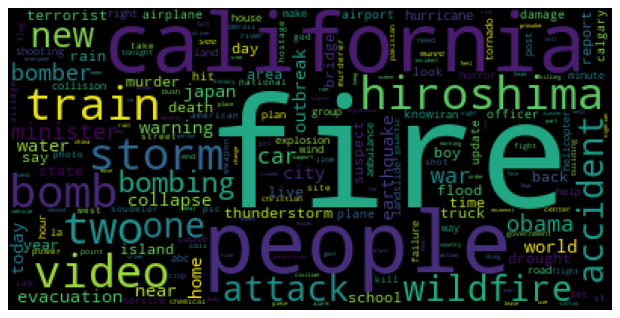

In [26]:
real = kgp.get_word_freqs(train[train['target'] == 1], 'text')

real = ' '.join(real.index)

word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

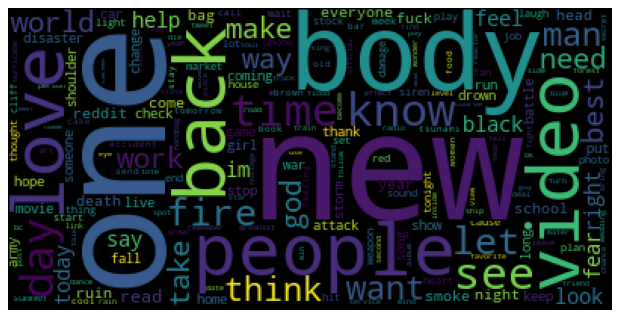

In [27]:
not_real = kgp.get_word_freqs(train[train['target'] == 0], 'text')

not_real = ' '.join(not_real.index)

word_cloud = WordCloud(max_font_size=100).generate(not_real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Classification with TFIDM and SVM

In [28]:
text = train['text']
y = train['target']

In [29]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [30]:
X.shape

(7613, 18076)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [32]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print()
    print('Classification_report')
    print(classification_report(y_test, y_pred))

In [33]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification_report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Classification with Word2Vec

In [34]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=e8053ecc64b72ec685290dce141bbb868714ec2393a7149d92c98f26548319d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-iocwyi_y/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [35]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()

In [36]:
x = 'cat dog'
doc = nlp(x)

doc.vector.shape

(300,)

In [37]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

train['vec'] = train['text'].apply(lambda x: get_vec(x))
train.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [39]:
 X = train['vec'].to_numpy()
 X = X.reshape(-1, 1)
 X

array([[array([-2.66233265e-01,  5.84306903e-02, -1.40463606e-01, -5.26588522e-02,
               -2.14530993e-03, -1.21439859e-01, -2.79072933e-02,  1.68873310e-01,
                2.79461779e-02,  2.27955627e+00, -1.11519486e-01, -3.06724869e-02,
                1.03592232e-01, -1.05660327e-01, -2.28190199e-01,  2.79889666e-02,
               -1.46331608e-01,  9.07751679e-01, -1.61362469e-01,  1.31339535e-01,
                4.89561353e-03, -1.84435159e-01,  4.26144543e-05,  8.49806145e-02,
                3.38713825e-02,  9.68834534e-02, -9.71195325e-02,  2.48919148e-03,
               -1.33919463e-01,  1.52661011e-01, -7.98190664e-03,  2.75931388e-01,
               -1.76876560e-01,  1.51992857e-01,  1.10118151e-01,  4.32643034e-02,
               -1.16125271e-01, -5.33458777e-03, -7.49662519e-02,  1.15647845e-01,
               -1.89541608e-01, -1.56142283e-02,  3.45693864e-02, -3.92473862e-02,
               -2.95386836e-02, -1.08877771e-01,  1.81476958e-02,  1.93963528e-01,
    

In [40]:
X.shape

(7613, 1)

In [42]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [43]:
X.shape

(7613, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [44]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification_report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 70.9 ms, sys: 0 ns, total: 70.9 ms
Wall time: 83.1 ms
